# Preamble

In [1]:
import os
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from intervaltree import Interval,IntervalTree

from time import time

import tensorflow as tf

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

C:\Apps\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Constants

In [5]:
d = 2048        # input dimensions
m = 128         # number of notes
fs = 44100      # samples/second
features = 0
labels = 1

restore_weights = True
folder = 'C:/Users/jq1n18/Downloads/thickstun2017learning-master/thickstun2017learning-master/mlp_small_2500/'

#musicnet = os.environ['MUSICNET']

### Load MusicNet

In [4]:
train_data = dict(np.load(open('C:\\Users\\jq1n18\\Downloads\\musicnet.npz','rb')))

In [6]:
# split our the test set
test_data = dict()
for id in (2303,2382,1819): # test set
    test_data[str(id)] = train_data.pop(str(id))
    
train_ids = train_data.keys()
test_ids = test_data.keys()
    
print len(train_data)
print len(test_data)

327
3


### Create the test set

In [7]:
# create the test set
Xtest = np.empty([3*7500,d])
Ytest = np.zeros([3*7500,m])
for i in range(len(test_ids)):
    for j in range(7500):
        index = fs+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[7500*i + j] = test_data[test_ids[i]][features][index:index+d]
        Xtest[7500*i + j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[i]][labels][index+d/2]:
            Ytest[7500*i + j,label.data[1]] = 1

# Raw MLP

In [8]:
tf.reset_default_graph()
tf.set_random_seed(999)

k = 2500

x = tf.placeholder(tf.float32, shape=[None,d])
y_ = tf.placeholder(tf.float32, shape=[None, m])

scale = 10e-7

w = tf.Variable(scale*tf.random_normal([d,k],seed=999))
beta = tf.Variable(scale*tf.random_normal([k,m],seed=999)) # x100

zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.matmul(x,w)))
y = tf.matmul(zx,beta)
L = tf.reduce_mean(tf.nn.l2_loss(y-y_))

init = tf.global_variables_initializer()

In [10]:
if restore_weights:
    weights = np.load(open(folder + 'w.npy','rb'))
    coefficients = np.load(open(folder + 'beta.npy','rb'))
    average_precision = list(np.load(open(folder + 'ap.npy','rb')))
    square_error = list(np.load(open(folder + 'loss.npy','rb')))
    weights_top = list(np.load(open(folder + 'wtop.npy','rb')))
    weights_bottom = list(np.load(open(folder + 'wbot.npy','rb')))

    sess = tf.Session()
    sess.run(w.assign(weights))
    sess.run(beta.assign(coefficients))
    init_lr = .01/16
else:
    square_error = []
    weights_top = []
    weights_bottom = []
    average_precision = []
    sess = tf.Session()
    sess.run(init)
    init_lr = .01

In [11]:
lr =  init_lr
opt = tf.train.GradientDescentOptimizer(lr)
train_step = opt.minimize(L)
Xmb = np.empty([len(train_data),d])
np.random.seed(999)
start = time()
print 'iter\tsquare_loss\tweights_top\tweights_bottom\tavg_precision\ttime'
for i in xrange(500000):
    if i % 100 == 0 and (i != 0 or len(square_error) == 0):
        square_error.append(sess.run(L, feed_dict={x: Xtest, y_: Ytest})/Xtest.shape[0])
        weights_top.append(np.mean(np.linalg.norm(beta.eval(session=sess),axis=0)))
        weights_bottom.append(np.mean(np.linalg.norm(w.eval(session=sess),axis=0)))
        
        Yhattestbase = sess.run(y,feed_dict={x: Xtest})
        yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
        yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])
        average_precision.append(average_precision_score(yflat, yhatflat))
        
        end = time()
        print i,'\t', round(square_error[-1],8),\
                '\t', round(weights_top[-1],8),\
                '\t', round(weights_bottom[-1],8),\
                '\t', round(average_precision[-1],8),\
                '\t', round(end-start,8)
        start = time()
    
    Ymb = np.zeros([len(train_data),m])
    for j in range(len(train_ids)):
        s = np.random.randint(d/2,len(train_data[train_ids[j]][features])-d/2)
        Xmb[j] = train_data[train_ids[j]][features][s-d/2:s+d/2]
        Xmb[j] /= np.linalg.norm(Xmb[j]) + 10e-6
        for label in train_data[train_ids[j]][labels][s]:
            Ymb[j,label.data[1]] = 1
    
    sess.run(train_step, feed_dict={x: Xmb, y_: Ymb})

iter	square_loss	weights_top	weights_bottom	avg_precision	time
100 	0.77227665 	2.04824209 	1.06340039 	0.56232109 	34.14100003
200 	0.77305668 	2.0482533 	1.06342185 	0.56171826 	26.102
300 	0.77247222 	2.04823422 	1.06344807 	0.56244051 	24.75500011
400 	0.77261875 	2.04829025 	1.06346989 	0.56232217 	24.02199984
500 	0.77244635 	2.04842901 	1.06351638 	0.5623799 	23.85899997
600 	0.77307083 	2.04845715 	1.06355059 	0.5620262 	23.52200007
700 	0.77246198 	2.04847383 	1.0635699 	0.56183369 	24.796
800 	0.77281285 	2.04846597 	1.06360352 	0.56147776 	23.32400012
900 	0.77246667 	2.04845476 	1.06362641 	0.56215277 	24.05299997
1000 	0.77305712 	2.04843616 	1.06364274 	0.56176745 	24.76899981
1100 	0.7733474 	2.04846501 	1.06366682 	0.5611466 	25.0
1200 	0.77239523 	2.04850721 	1.06370366 	0.56199921 	23.35500002
1300 	0.7719625 	2.04843044 	1.06371772 	0.5623902 	23.52900004
1400 	0.77370972 	2.04856133 	1.06375229 	0.56086188 	24.25900006
1500 	0.77277292 	2.04848194 	1.06376445 	0.561

12600 	0.77244696 	2.05192184 	1.06708717 	0.56230588 	28.86899996
12700 	0.77252951 	2.05204248 	1.06712759 	0.56164765 	28.51300001
12800 	0.77288437 	2.05208921 	1.06716657 	0.56213249 	28.0860002
12900 	0.77332144 	2.05218315 	1.06721032 	0.56133006 	28.25999999
13000 	0.77370677 	2.05217314 	1.06723773 	0.5616674 	28.63199997
13100 	0.77223984 	2.05205917 	1.06725335 	0.56242608 	29.28699994
13200 	0.77178681 	2.05200624 	1.06727314 	0.56271315 	29.70499992
13300 	0.77082656 	2.05217075 	1.06731319 	0.56341258 	29.95099998
13400 	0.77190122 	2.05215526 	1.06733012 	0.56268506 	29.39899993
13500 	0.77293767 	2.05208111 	1.06735909 	0.56172017 	30.36599994
13600 	0.77191667 	2.05226755 	1.06740308 	0.56235196 	29.37800002
13700 	0.7728066 	2.05231953 	1.06743383 	0.56183855 	29.69500017
13800 	0.77259714 	2.05231977 	1.06746244 	0.56177207 	29.20799994
13900 	0.77252517 	2.05232501 	1.06748295 	0.56224636 	29.10500002
14000 	0.77342943 	2.0523963 	1.06751299 	0.5615036 	28.69299984


25000 	0.7721599 	2.05704737 	1.0711062 	0.56257512 	29.398
25100 	0.77182118 	2.05708599 	1.07114124 	0.56282814 	29.38400006
25200 	0.77205026 	2.05715895 	1.07117271 	0.56225788 	30.02399993
25300 	0.77197378 	2.05721259 	1.07121563 	0.5621491 	29.27200007
25400 	0.77149957 	2.05722141 	1.07123864 	0.56276892 	29.81999993
25500 	0.77329236 	2.0572722 	1.07127893 	0.56165914 	30.58500004
25600 	0.77178611 	2.05732036 	1.07131422 	0.56259574 	31.58699989
25700 	0.77214887 	2.0573678 	1.07134748 	0.56265211 	30.33299994
25800 	0.7723934 	2.05747199 	1.07139146 	0.56252147 	30.52600002
25900 	0.7733237 	2.0575676 	1.07142758 	0.56184479 	29.72600007
26000 	0.77365972 	2.05766106 	1.07146168 	0.56119474 	29.87899995
26100 	0.771325 	2.05779982 	1.07150984 	0.56300811 	29.26300001
26200 	0.77254653 	2.05777121 	1.0715369 	0.56159502 	29.52399993
26300 	0.77155174 	2.05779314 	1.07156432 	0.56255762 	29.96499991
26400 	0.7718809 	2.05780482 	1.07159889 	0.56208692 	29.25699997
26500 	0.773

37400 	0.77199635 	2.06281304 	1.07521892 	0.56253386 	29.86400008
37500 	0.77120052 	2.06280732 	1.07526231 	0.56336403 	29.93300009
37600 	0.77182144 	2.06286287 	1.07529867 	0.56235938 	29.84799981
37700 	0.77237196 	2.06297851 	1.07532966 	0.56181296 	29.67000008
37800 	0.77302031 	2.06295323 	1.07536566 	0.56197509 	29.93099999
37900 	0.7727033 	2.06309867 	1.07540429 	0.56178416 	30.22800016
38000 	0.7734224 	2.06311083 	1.0754348 	0.56174206 	30.10299993
38100 	0.77182917 	2.06319165 	1.07547343 	0.56235496 	29.33599997
38200 	0.77241111 	2.06314731 	1.07549667 	0.56215028 	30.06699991
38300 	0.77182292 	2.0632329 	1.07553279 	0.56234573 	29.421
38400 	0.77111753 	2.06311464 	1.07554257 	0.56288843 	29.33899999
38500 	0.77111007 	2.06329393 	1.07558107 	0.56283511 	29.53699994
38600 	0.77188559 	2.06326914 	1.07560992 	0.56234346 	29.99099994
38700 	0.77239757 	2.06331062 	1.07564771 	0.56230465 	29.27100015
38800 	0.77354826 	2.06350946 	1.07569146 	0.56142659 	26.75399995
3890

49800 	0.77258646 	2.06832314 	1.07929301 	0.56212056 	27.81800008
49900 	0.77049184 	2.06841373 	1.07933128 	0.56393411 	27.38199997
50000 	0.77123438 	2.06851292 	1.07937503 	0.56345423 	27.15700006
50100 	0.77095417 	2.06852484 	1.07940471 	0.56349059 	27.83599997
50200 	0.77109826 	2.06849909 	1.07942927 	0.56324461 	27.95500016
50300 	0.77136571 	2.06853867 	1.07945347 	0.5630148 	28.28399992
50400 	0.77107873 	2.06852627 	1.07948017 	0.563473 	28.41199994
50500 	0.77158168 	2.06860781 	1.07951403 	0.56286746 	28.21700001
50600 	0.77140503 	2.06864405 	1.07955992 	0.56286612 	28.72300005
50700 	0.77411753 	2.06875539 	1.07959676 	0.56143768 	28.57299995
50800 	0.7719934 	2.06870842 	1.07960463 	0.56262974 	28.76300001
50900 	0.77248186 	2.06875825 	1.07963717 	0.56165687 	29.07400012
51000 	0.77161059 	2.06881523 	1.07966793 	0.56290176 	29.1309998
51100 	0.77200078 	2.0690093 	1.07972789 	0.56256794 	29.35700011
51200 	0.7720309 	2.0691061 	1.0797652 	0.56220483 	30.19199991
5130

62200 	0.77243516 	2.07447052 	1.08347309 	0.56194618 	29.12700009
62300 	0.7713625 	2.07445002 	1.08349359 	0.56295221 	28.58800006
62400 	0.77196337 	2.07454824 	1.08353007 	0.56279031 	28.15499997
62500 	0.77146693 	2.07468224 	1.08358264 	0.56287654 	27.86299992
62600 	0.7725572 	2.07463884 	1.08360112 	0.56223298 	27.98900008
62700 	0.77213038 	2.07463336 	1.08362365 	0.56181949 	28.80299997
62800 	0.77217161 	2.07471919 	1.08366597 	0.56255554 	28.86199999
62900 	0.77122465 	2.07486534 	1.08370042 	0.56295133 	28.82999992
63000 	0.77282092 	2.07493448 	1.08374298 	0.56148559 	28.84899998
63100 	0.77205521 	2.07490468 	1.08376896 	0.56175302 	29.75600004
63200 	0.77218524 	2.07491159 	1.08380568 	0.56246974 	29.76100016
63300 	0.77216562 	2.07495618 	1.08382189 	0.56221579 	30.53699994
63400 	0.77164618 	2.07505393 	1.08385932 	0.56275221 	29.71000004
63500 	0.77103438 	2.07522488 	1.0839107 	0.56314727 	30.02099991
63600 	0.7725717 	2.07535362 	1.08395088 	0.56181681 	29.81699991

KeyboardInterrupt: 

In [25]:
print label.data[1]

77


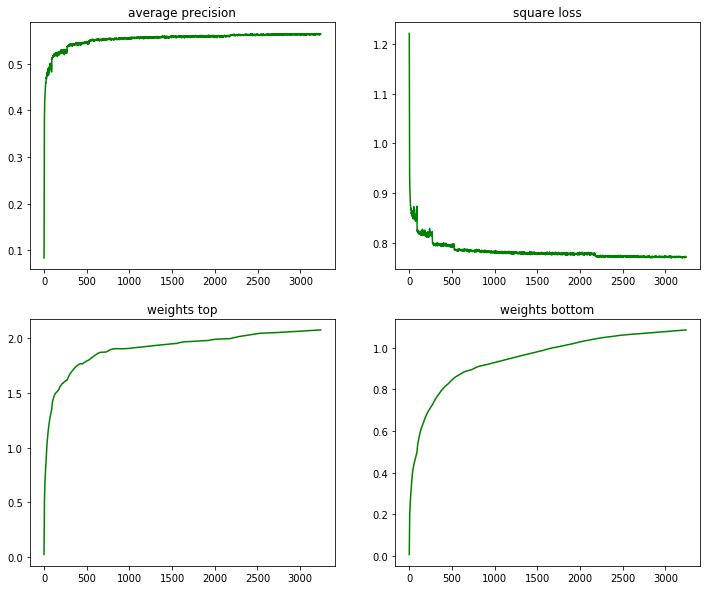

In [26]:
burnin=1
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(average_precision[burnin:],color='g')
ax2.set_title('square loss')
ax2.plot(square_error[burnin:],color='g')
ax3.set_title('weights top')
ax3.plot(weights_top[burnin:],color='g')
ax4.set_title('weights bottom')
ax4.plot(weights_bottom[burnin:],color='g')

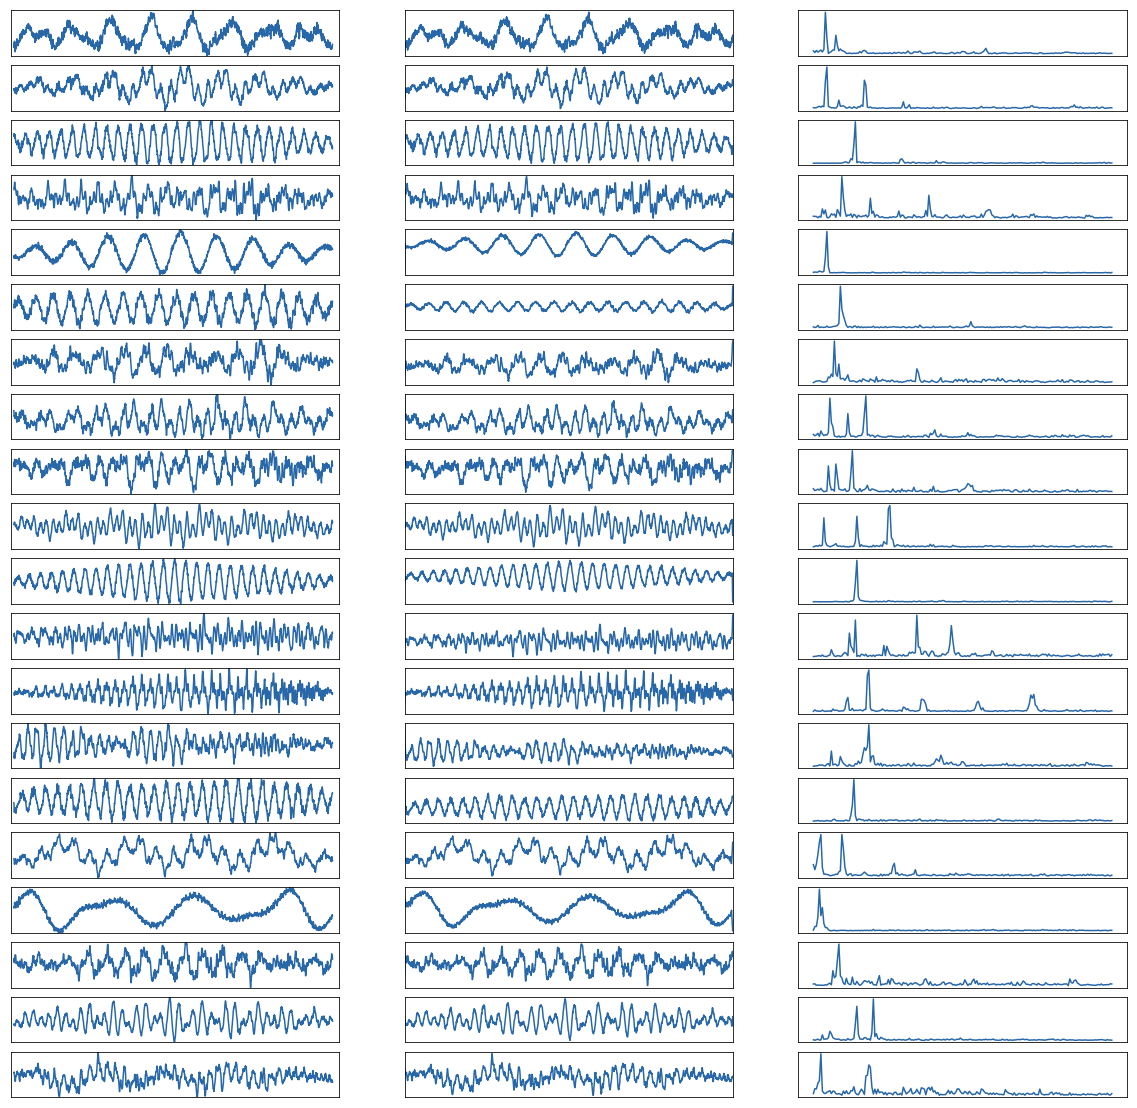

In [27]:
offset = 20
window = 2048
f, ax = plt.subplots(20,3, sharey=False)
f.set_figheight(20)
f.set_figwidth(20)
weights = w.eval(session=sess)
for i in range(20):
    ax[i,0].plot(weights[10:-10,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,0].set_xlim([-20,d+20])
    ax[i,0].set_ylim([np.min(weights[10:-10,i+offset]),np.max(weights[10:-10,i+offset])])
    ax[i,0].set_xticklabels([])
    ax[i,0].set_yticklabels([])
    ax[i,1].plot(weights[d/2-1024:d/2+1024,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,1].set_xticklabels([])
    ax[i,1].set_yticklabels([])
    ax[i,1].set_xlim([0,d])
    ax[i,2].plot(np.abs(fft(weights[:,i+offset]))[0:200], color=(41/255.,104/255.,168/255.))
    ax[i,2].set_xticklabels([])
    ax[i,2].set_yticklabels([])
    
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [28]:
folder = 'C:/Users/jq1n18/Downloads/thickstun2017learning-master/thickstun2017learning-master/mlp_small_2500/'

weights = w.eval(session=sess)
coefficients = beta.eval(session=sess)

np.save(open(folder + 'w.npy','wb'),weights)
np.save(open(folder + 'beta.npy','wb'),coefficients)
np.save(open(folder + 'ap.npy','wb'),average_precision)
np.save(open(folder + 'loss.npy','wb'),square_error)
np.save(open(folder + 'wtop.npy','wb'),weights_top)
np.save(open(folder + 'wbot.npy','wb'),weights_bottom)

# MIREX evaluation

In [30]:
!pip install mir_eval

  Running setup.py bdist_wheel for mir-eval: started
  Running setup.py bdist_wheel for mir-eval: finished with status 'done'
  Stored in directory: C:\Users\jq1n18\AppData\Local\pip\Cache\wheels\69\d2\fe\892fae0039b51e3774a92daac135e45268ff5f52f28b99f4e4
  Running setup.py bdist_wheel for future: started
  Running setup.py bdist_wheel for future: finished with status 'done'
  Stored in directory: C:\Users\jq1n18\AppData\Local\pip\Cache\wheels\0c\61\d2\d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built mir-eval future


You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [31]:
import mir_eval

In [32]:
Xvalidation = np.zeros([50*len(train_data),d])
Yvalidation = np.zeros([50*len(train_data),m])
for i in range(len(train_data)):
    # 50 random samples from each recording
    s = np.random.randint(d/2,len(train_data[train_ids[i]][features])-d/2,size=100)
    for j in range(50):
        Xvalidation[50*i+j] = train_data[train_ids[i]][features][s[j]-d/2:s[j]+d/2]
        Xvalidation[50*i+j] /= np.linalg.norm(Xvalidation[50*i+j]) + 10e-6
        # label stuff that's on in the center of the window
        for label in train_data[train_ids[i]][labels][s[j]]:
            Yvalidation[50*i+j,label.data[1]] = 1

In [33]:
Yhattestbase = sess.run(y,feed_dict={x: Xtest})
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])
print average_precision_score(yflat, yhatflat)

0.5634368852582816


In [35]:
def estimate(X,subdiv=50):
    return np.dot(X,w)

In [ ]:
Yhatbase = estimate(Xvalidation)

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [ ]:
Yhatbase = estimate(Xtest)

Yhat = Yhatbase>c
Yhatlist = []
Ytestlist = []
for i in range(len(Yhat)):
    fhat = []
    ftest = []
    for note in range(128):
        if Yhat[i][note] == 1:
            fhat.append(440.*2**((note - 69.)/12.))
        if Ytest[i][note] == 1:
            ftest.append(440.*2**((note - 69.)/12.))
    Yhatlist.append(np.array(fhat))
    Ytestlist.append(np.array(ftest))

In [ ]:
P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
mir_eval.multipitch.metrics(np.arange(len(Ytestlist))/100.,Ytestlist,np.arange(len(Yhatlist))/100.,Yhatlist)

print P
print R
print Acc
print Etot
print Esub
print Emiss
print Efa

print '-----'

print cP
print cR
print cAcc
print cEtot
print cEsub
print cEmiss
print cEfa

# Precision/Recall

In [ ]:
fs = 44100
m = 128

composition = 2
            
# create the test set
Xtest = np.empty([7500,d])
Ytest = np.zeros([7500,m])
for i in range(1):
    for j in range(7500):
        index = fs+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[j] = test_data[test_ids[composition]][features][index:index+d]
        Xtest[j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[composition]][labels][index+d/2]:
            Ytest[7500*i + j,label.data[1]] = 1

In [ ]:
print test_ids[composition]

In [ ]:
Yhatbase = estimate(Xvalidation)

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [ ]:
plt.plot(R,P)

In [ ]:
Yhattestbase = estimate(Xtest)
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest))
F = 2*(P*R)/(P+R)
print P
print R
print F

In [ ]:
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision, recall, _ = precision_recall_curve(yflat, yhatflat)
ap = average_precision_score(yflat, yhatflat)
plt.plot(recall,precision)
print ap

In [ ]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure()
plt.plot(recall,precision)
fig.axes[0].set_xlabel('recall')
fig.axes[0].set_ylabel('precision')

plt.tight_layout()
plt.savefig('mlp2500_pr.eps',format='eps', dpi=1000)